# Supervised Text Classification Final: Health and Wellness Classification

This document is the final project for DTSA 5798: Supervised Text Classification. The project's main goal is to build and hypertune a text classification model using Bidirectional Encoder Representations from Transformers (BERT) that is capable of classifying articles as health or non-health related to help a company advertise to their target market.

This project aims to improve upon previous course assignments in several key ways:

1. **Increase Training Data:** This will involve including more non-health articles, negative cases, for the model to train on.

2. **Utilize adjusted learning rate with Adam Optimization:** Instead of a fixed learning rate, a form of Adam Optimization, a type of stochastic gradient descent, will be implemented to dynamically update the learning rate during training.

3. **Leverage more recent versions of BERT with TensorFlow and Keras:** The ktrain API wrapper will be bypassed in favor of using TensorFlow and Keras directly to implement the latest versions of BERT.

***NOTE: This notebook can take several hours to run depending on computational resources used and may time out if you are using the free version of Google Colab. If you are interested in seeing the results without running the notebook I reccomend viewing the PDF of notebook with all outputs on my GitHub repository here: https://github.com/arwhit/news_article_classification***

## Installs and Imports

In [ ]:
%%capture
!pip install -U "tensorflow-text==2.13.*"
!pip install "tf-models-official==2.13.*"
import json
import pandas as pd
import numpy as np
import os
import shutil
import sklearn.model_selection as sk
from sklearn.metrics import precision_recall_fscore_support
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt

## Ensure Runtime Type is at a minimum a GPU

If the runtime is not connected to a GPU do the following: Runtime > Change Runtime Type > GPU

The following code snippet from the ktrain lab shows runtime GPU information

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun  2 23:51:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load the data

For ease of use the data file has been uploaded and can be accessed from a public GitHub repository

In [ ]:
url='https://raw.githubusercontent.com/arwhit/news_article_classification/main/news_category_trainingdata.json'
reviews = pd.read_json(url)
reviews.head()



,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


## Data Cleaning

We will follow a similar approach to the ktrain lab for data preprocessing. Here are the steps involved:

1. **Combine Text Columns:** All text data used for training will be merged into a single column.

2. **Create Binary Label:** A binary label for "healthy living" will be created. Articles classified as "healthy living" will be assigned a label of 1, while all other news categories will be assigned a label of 0.

In [ ]:
#combine the headline and short description text
reviews['combined_text'] = reviews['headline'] + ' ' + reviews['short_description']
#create the healthy classification
reviews['healthy'] = np.where((reviews['category'] == 'HEALTHY LIVING'), 1, 0)

lets also preview some articles classified as healthy

In [ ]:
reviews[reviews['healthy']==1].sample(5)

,category,headline,authors,link,short_description,date,combined_text,healthy
22288,HEALTHY LIVING,4 Ways To Beat Your Bad Day,"meQuilibrium, ContributorPersonalized Stress M...",https://www.huffingtonpost.com/entry/4-ways-to...,"When something goes wrong, it’s tempting to wr...",2017-07-05,4 Ways To Beat Your Bad Day When something goe...,1
38806,HEALTHY LIVING,New Year's Resolutions Are Bound To Fail. Try ...,Carolyn Gregoire,https://www.huffingtonpost.com/entry/new-years...,Skip the all-or-none resolutions this year.,2016-12-28,New Year's Resolutions Are Bound To Fail. Try ...,1
21425,HEALTHY LIVING,How To Deal With The Side Effects Of Breast Ca...,"Barbara Jacoby, ContributorAward winning blogg...",https://www.huffingtonpost.com/entry/dealing-w...,Anyone who has watched television has most lik...,2017-07-15,How To Deal With The Side Effects Of Breast Ca...,1
109338,HEALTHY LIVING,Got Yoga? Insights and Breath Into the Heart a...,"Amy Elias, MS, ContributorCulture, Change and ...",https://www.huffingtonpost.com/entry/got-yoga-...,"When your yoga teacher, or the one that lives ...",2014-10-15,Got Yoga? Insights and Breath Into the Heart a...,1
69221,HEALTHY LIVING,Pregnant Women Shouldn't Travel To Countries W...,Anna Almendrala,https://www.huffingtonpost.com/entry/cdc-trave...,The mosquito-borne illness may cause birth def...,2016-01-16,Pregnant Women Shouldn't Travel To Countries W...,1


Let's also consider the overall split of health related articles

In [ ]:
print('Of ', str(len(reviews)), ' articles, ', str(len(reviews[reviews['healthy']==1])), ' are healthy living articles')
print(str(len(reviews[reviews['healthy']==1])*100/len(reviews)), '% of articles are health related')

Of  200853  articles,  6694  are healthy living articles
3.332785669121198 % of articles are health related


## Data Preprocessing
To enhance model performance compared to previous labs, we will incorporate a larger dataset. Specifically, the dataset will comprise:

* **Healthy Living Articles:** One-third (6694 articles) will consist exclusively of health-related articles.

* **Non-Health Living Articles:** The remaining two-thirds (10041 articles) will encompass articles from non-health-related news categories.

**Preprocessing and Stratification:**

During preprocessing, we will create a stratified train/test split. This ensures the ratio of health and non-health articles is preserved in both the training set (90%) and the testing set (10%). This approach helps mitigate potential biases and leads to a more robust model.

In [ ]:
#define columns to keep
cols=['combined_text','healthy']

#Balanced Dataset with specified random state for reproducibility
sample_amount = 6694
healthy = reviews[reviews['healthy'] == 1].sample(n=sample_amount, random_state=5)
not_healthy = reviews[reviews['healthy'] == 0].sample(n=round(sample_amount*1.5), random_state=5)
reviews = pd.concat([healthy, not_healthy])
reviews=reviews[cols]
#Shuffle
reviews = reviews.sample(frac=1, random_state=5).reset_index(drop=True)
#Create train/test split
xtrain, xtest, ytrain, ytest = sk.train_test_split(reviews['combined_text'], reviews['healthy'],
                                                       test_size=0.1,
                                                       #keep train and test ratios equal
                                                       stratify=reviews['healthy'],
                                                       random_state=5)

**Vectorization and Preprocessing Integration:**

While the text will eventually require vectorization, we will integrate the preprocessing steps into the model itself. This approach allows for future text to be passed directly into the model with minimal additional preprocessing.

**BERT Model Selection:**

Several BERT model variations are available. However, due to limited GPU resources, a smaller BERT model with 4 transformer blocks, 256 Hidden dimmensions, and 4 attention heads will be utilized. This greatly reduces the number of paramaters compared to the standard BERT model that has 12 transformer blocks, 768 hidden dimmensions, and 12 attention heads.

**Example of Vectorized Text:**

Below is an example of what the text might look like after undergoing vectorization:

In [ ]:
#Example of text preprocessing and encoding
example=['This is a sample text']
bert_preprocess_model = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3")
text_preprocessed = bert_preprocess_model(example)
bert_model = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/bert-en-uncased-l-4-h-256-a-4/2")
results=bert_model(text_preprocessed)
print(f'Pooled Outputs Values:{results["pooled_output"][0, :10]}')

Pooled Outputs Values:[-0.9903946   0.08152626 -0.9994572  -0.9390198   0.09298737  0.99392444
 -0.11591559 -0.10250869  0.03855637  0.95338476]


# Build and Fine Tuning the Models
Now it's time to build, train, and fine-tune the actual model. Since BERT is pre-trained and we are fine-tuning, the model will consist of relatively few layers:

1. An input layer
2. A preprocessing layer
3. The BERT encoding layer
4. A dropout layer to prevent overfitting
5. A dense layer for the final prediction

In an attempt to train on more data, the dataset is no longer balanced, so accuracy is likely not an ideal training metric. To efficiently spend advertising dollars, we should aim to minimize the possibility of false postives, non health related articles wrongly identified as health articles. In order to ensure articles classified as healthy are actualy health related articles, ***precision*** will be used as the primary model evaluation metric for both training and evaluation.

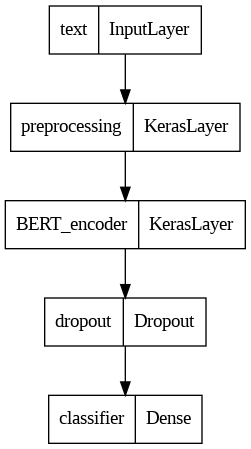

In [ ]:
#Specify BERT Model to be used
preprocess_url="https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3"
encoding_url="https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/bert-en-uncased-l-4-h-256-a-4/2"

#Create the Model
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preprocess_url, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(encoding_url, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

#Visualize the Model
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [ ]:
#Make results reproducable
tf.keras.utils.set_random_seed(5)
#Specify hyperparameters
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.keras.metrics.Precision()
#(note most BERT models require a smaller learning rate than what is default in tf and keras)
opt = tf.keras.optimizers.AdamW(learning_rate=3e-5)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
#Compile the models
classifier_model = build_classifier_model()
classifier_model.compile(optimizer=opt, loss=loss, metrics=metrics)
#Fit the models
history = classifier_model.fit(xtrain, ytrain, batch_size=16, epochs=5, validation_data=(xtest, ytest), callbacks=[callback])

Epoch 1/5
942/942 [==============================] - 948s 995ms/step - loss: 0.4113 - precision: 0.7949 - val_loss: 0.3339 - val_precision: 0.8293
Epoch 2/5
942/942 [==============================] - 912s 968ms/step - loss: 0.3156 - precision: 0.8360 - val_loss: 0.3240 - val_precision: 0.7931
Epoch 3/5
942/942 [==============================] - 908s 964ms/step - loss: 0.2563 - precision: 0.8718 - val_loss: 0.3321 - val_precision: 0.8712
Epoch 4/5
942/942 [==============================] - 933s 991ms/step - loss: 0.2040 - precision: 0.9011 - val_loss: 0.3443 - val_precision: 0.8516
Epoch 5/5
942/942 [==============================] - 918s 974ms/step - loss: 0.1576 - precision: 0.9244 - val_loss: 0.4142 - val_precision: 0.8621


## Model Evaluation
We will visualize the model's performance throughout the training process to gain insights into its learning behavior. This visualization will help us identify potential issues like overfitting or underfitting. To achieve this, we will leverage techniques outlined in a helpful tutorial (source 5).

<ipython-input-11-6cefcef0beb9>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  grayscale_cmap = plt.cm.get_cmap('gray')


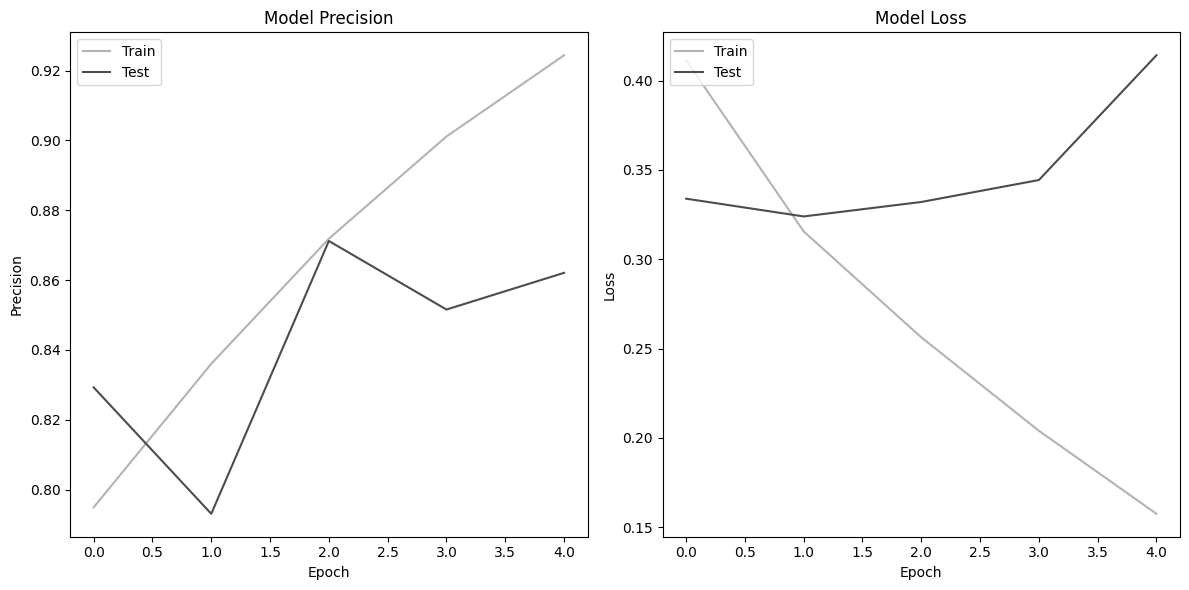

In [ ]:
#define plot parameters
plt.figure(figsize=(12, 6))
grayscale_cmap = plt.cm.get_cmap('gray')
train_color = grayscale_cmap(0.7)
test_color = grayscale_cmap(0.3)

# Plot accuracy, subplot at position 1, row 1, column 1
plt.subplot(1, 2, 1)
plt.plot(history.history['precision'], color=train_color, label='Train')
plt.plot(history.history['val_precision'], color=test_color, label='Test')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot loss, subplot at position 1, row 1, column 2
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], color=train_color, label='Train')
plt.plot(history.history['val_loss'], color=test_color, label='Test')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()

Now let's extract key evaluation metrics from the trained model. These metrics will allow us to assess the model's performance and compare it to Dr. Vargos' benchmark. This comparison will help us determine if the model achieves a performance level comparable to or exceeding the established benchmark.

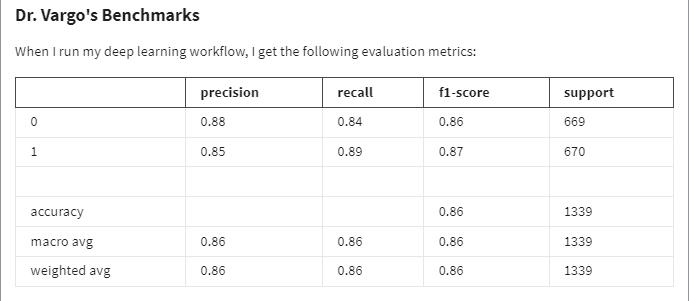


In [ ]:
#predict class
y_pred = classifier_model.predict(xtest)
#round to match orgininal labels
for i in range(len(y_pred)):
  if y_pred[i] < 0:
    y_pred[i] = 0
  else:
    y_pred[i] = 1

53/53 [==============================] - 28s 518ms/step


In [ ]:
# Unbalanced Results
# Use sklearn to calculate key metrics
results = precision_recall_fscore_support(y_true=ytest, y_pred=y_pred)
# create metrics dataframe
mets = pd.DataFrame({'Precision': results[0],
                   'Recall': results[1],
                   'F1-Score': results[2],
                   'Support': results[3]},
                  index=['Non Health', 'Health'])
print(mets)

            Precision    Recall  F1-Score  Support
Non Health   0.882066  0.901394  0.891626     1004
Health       0.847222  0.819403  0.833080      670


##Conclusions
Fine-tuning pre-trained models like BERT offers a powerful approach to achieving good results on marketing classification tasks.

While less computationally expensive than training from scratch, fine-tuning still requires significant resources which is a limiting factor for free-tier Google Colab users wishing to fine tune larger models.

Simpler linear models, like the onse shown in the class tutorials, can be trained more quickly in Colab and have relatively similar reuslts to smaller BERT models, but I suspect the performace gap would widen in a real-world scenario where a company with a substantial advertising budget is willing to invest in computational resources above what is availalbe for free through google colab to develop robust fine-tuned models

##Sources

1. https://www.tensorflow.org/text/tutorials/classify_text_with_bert
2. https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
3. https://www.kaggle.com/models/tensorflow/bert
4. https://arxiv.org/pdf/1810.04805